In [25]:
import glob
import os.path
import numpy as np
import pyedflib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tqdm
import mne
from scipy.signal import welch,stft
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import euclidean

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

### Feature extraction and Filter

In [3]:
def primary_feature_extract(signal):
    
    # Standard scaling signal and determining different point statistics of signals
    signal = (signal - np.mean(signal)) / np.std(signal)
    mean = np.mean(signal)
    std = np.std(signal)
    sample_entropy = np.log(np.std(np.diff(signal)))
    fuzzy_entropy = -np.log(euclidean(signal[:-1], signal[1:]) / len(signal))
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return [mean, std, sample_entropy, fuzzy_entropy, skewness, kurt]

def secondary_feature_extract(data, fs, window_length_sec=3):
    
    # Short Time Fourier Transform of the signals to divide longer time signals into shorter segments of equal length
    f, t, Zxx = stft(data, fs, nperseg=window_length_sec*fs)
    
    power = np.mean(np.abs(Zxx)**2, axis=1) 

    return power

def extract_dependent_features_with_timestamps(file_name):

    # Reading raw edf file
    edf_raw = mne.io.read_raw_edf(file_name, preload=True)
    
    # Filtering subset of channels between the mentioned lowerpass and highpass
    edf_raw.filter(1., 50., fir_design='firwin')

    # Picking EEG channel type
    edf_raw.pick_types(meg=False, eeg=True, eog=False)

    # Filtering samples based on window length
    window_length = 3
    
    # Storing fequnecy of the test
    sfreq = edf_raw.info['sfreq'] 
    window_samples = int(window_length * sfreq)

    features_with_timestamps = []

    for start in range(0, len(edf_raw.times), window_samples):
        end = start + window_samples
        if end > len(edf_raw.times):
            break

        window_data, times = edf_raw[:, start:end]
        window_data = np.squeeze(window_data)

        timestamp = edf_raw.times[start]

        # Sending postion of data based on window sample to extract primary and secondary features
        for channel_data in window_data:
            primary_features = primary_feature_extract(channel_data)
            secondary_features = secondary_feature_extract(channel_data, sfreq)
            features_combined = np.concatenate([[timestamp], primary_features, secondary_features])
            features_with_timestamps.append(features_combined)

    return np.array(features_with_timestamps)

a= extract_dependent_features_with_timestamps("data/chb01/chb01_03.edf")

Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.5s finished


### Data Preprocessing

In [4]:

def extract_independent_feature(summary_file_path, edf_path):
    edf_file_name = os.path.basename(edf_path)
    
    seizure_start_time = None
    seizure_end_time = None

    with open(summary_file_path, 'r') as file:
        lines = file.readlines()

    found = False

    for line in lines:
        if "File Name: " + edf_file_name in line:
            found = True
        if found:
            if "Number of Seizures in File: 0" in line:
                return None, None 
            if "Seizure Start Time:" in line:
                seizure_start_time = int(line.split(": ")[1].split(" ")[0])
            if "Seizure End Time:" in line:
                seizure_end_time = int(line.split(": ")[1].split(" ")[0])
                break 
    return seizure_start_time, seizure_end_time

In [5]:
def data_extract_with_labels(edf_path, summary_file_path):

    # Extracting dependent features
    X = extract_dependent_features_with_timestamps(edf_path)
    
    # Extracting target variable
    seizure_start_time, seizure_end_time = extract_independent_feature(summary_file_path, edf_path)
    y = np.array([1 if seizure_start_time <= row[0] <= seizure_end_time else 0 for row in X])

    X = X[:,1:]
    return X,y


def data_ingest(sub_code,initial_path):
  
    # Storing path of all edf files of each subject in a sorted list by tracing through driectory using glob
    edf_path = sorted(glob.glob(os.path.join(initial_path, "chb{:02d}/*.edf".format(sub_code))))
    
    # Extracting path of summary file within each subject
    summary_file_path = os.path.join(initial_path, "chb{:02d}/chb{:02d}-summary.txt".format(sub_code, sub_code))
    
    full_X = []
    full_y = []
    
    # For each file path extracting data and creating X(dependent variable) and y(independent variables)
    for edf_path in edf_path:
        X, y = data_extract_with_labels(edf_path, summary_file_path)
        full_X.append(X)
        full_y.append(y)
    return full_X,full_y



In [6]:
# Data preprocessing for Subject 1
sub_code= 1
initial_path = "data"
full_X1,full_y1 = data_ingest(sub_code,initial_path)

# Vertical stacking of all the dependent variables returned from data_ingest() for Subject 1
X1 = np.vstack(full_X1)
# Concatenation of all target variables returned from data_ingest() for Subject 1
y1 = np.concatenate(full_y1)

Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb01\chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished


Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb01\chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb01\chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished


Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb01\chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb01\chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished


Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb01\chb01_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 595199  =      0.000 ...  2324.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


In [7]:
# Data preprocessing for Subject 5
sub_code= 5
initial_path = "data"
full_X5,full_y5 = data_ingest(sub_code,initial_path)

# Vertical stacking of all the dependent variables returned from data_ingest() for Subject 5
X5 = np.vstack(full_X5)

# Concatenation of all target variables returned from data_ingest() for Subject 5
y5 = np.concatenate(full_y5)

Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb05\chb05_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb05\chb05_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished


Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb05\chb05_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished


Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb05\chb05_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished


Extracting EDF parameters from C:\Users\deepi\Documents\2023 - DAE Year 1\Semester 1\Foundations Data Analytics Engineering\Projects\FDA Project3\CHB-MIT-data-preprocessing-and-prediction-main\CHB-MIT-data-preprocessing-and-prediction-main\data\chb05\chb05_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\deepi\AppData\Local\Temp\ipykernel_8844\542965232.py:25: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_raw = mne.io.read_raw_edf(file_name, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished


### Data Splitting

In [8]:
# Vertical stacking of all the dependent variables returned from data_ingest()
X = np.vstack([X1,X5])

# Concatenation of all target variables returned from data_ingest()
y = np.concatenate([y1,y5])

# Upsampling the monority classes of target variable to handle class imbalance bias
sm = SMOTE()

X_smote, y_smote = sm.fit_resample(X, y)

# Spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=0)

# Decision tree model
dtc_model = DecisionTreeClassifier(random_state=0)
dtc_model.fit(X_train, y_train)


y_pred_dtc = dtc_model.predict(X_test)

#Decision tree evaluation metrics
acc_dtc = accuracy_score(y_test, y_pred_dtc)
print("Accuracy of Decision Tree Classifier:", acc_dtc)

f1_dtc = f1_score(y_test, y_pred_dtc)
print("F1 Score of Decision Tree Classifier:", f1_dtc)

Accuracy of Decision Tree Classifier: 0.8752118857968766
F1 Score of Decision Tree Classifier: 0.8774973657030182


In [14]:
X_train.shape

(224997, 391)

### Model Selecting, Training, Evaluation

In [18]:
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Random Forest evaluation metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest Classifier:", acc_rf)

f1_rf = f1_score(y_test, y_pred_rf)
print("F1 Score of Random Forest Classifier:", f1_rf)

Accuracy of Random Forest Classifier: 0.9770813456672336
F1 Score of Random Forest Classifier: 0.1038118410381184


In [19]:
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the CNN model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')


Epoch 1/10


7233/7233 [==============================] - 50s 7ms/step - loss: 0.1126 - accuracy: 0.9759 - val_loss: 0.1177 - val_accuracy: 0.9743
Epoch 2/10
7233/7233 [==============================] - 39s 5ms/step - loss: 0.1106 - accuracy: 0.9760 - val_loss: 0.1209 - val_accuracy: 0.9743
Epoch 3/10
7233/7233 [==============================] - 36s 5ms/step - loss: 0.1099 - accuracy: 0.9760 - val_loss: 0.1155 - val_accuracy: 0.9743
Epoch 4/10
7233/7233 [==============================] - 41s 6ms/step - loss: 0.1098 - accuracy: 0.9760 - val_loss: 0.1160 - val_accuracy: 0.9743
Epoch 5/10
7233/7233 [==============================] - 48s 7ms/step - loss: 0.1095 - accuracy: 0.9760 - val_loss: 0.1163 - val_accuracy: 0.9743
Epoch 6/10
7233/7233 [==============================] - 51s 7ms/step - loss: 0.1094 - accuracy: 0.9760 - val_loss: 0.1148 - val_accuracy: 0.9743
Epoch 7/10
7233/7233 [==============================] - 56s 8ms/step - loss: 0.1092 - accuracy: 0.9760 - val_loss: 0.1155 - val_

### Testing

In [20]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.05).astype(int)  # Convert probabilities to binary predictions

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.4f}')

2009/2009 [==============================] - 4s 2ms/step
F1 score: 0.0921


### Results and Visualization

In [21]:
data = {
    'Model': ['Random Forest', 'Decision Tree', 'CNN'],
    'Accuracy': [acc_rf, acc_dtc, accuracy],
    'F1 Score': [f1_rf, f1_dtc, f1]
}

df = pd.DataFrame(data)
print(df)

           Model  Accuracy  F1 Score
0  Random Forest  0.977081  0.103812
1  Decision Tree  0.875212  0.877497
2            CNN  0.975655  0.092074


<Axes: >

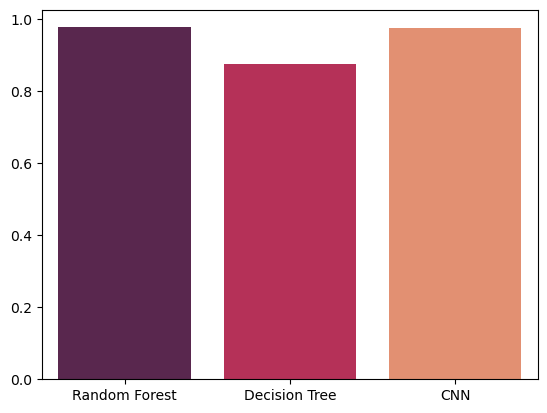

In [29]:
sns.barplot(data=data, x='Model', y='Accuracy', palette='rocket')

<Axes: >

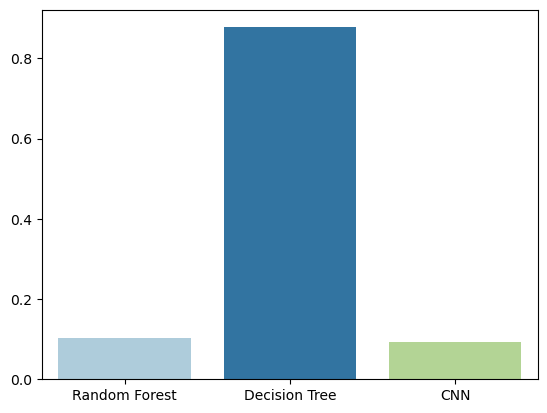

In [30]:
sns.barplot(data=data, x='Model', y='F1 Score', palette='Paired')